## Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/핀테크 Final')

In [ ]:
import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [ ]:
train = pd.read_csv('data10000.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((6498, 12), (3000, 12))

In [ ]:
train.head()

,gender,age,income,knowledge,exp,risk,term,s1,s2,s3,s4,s5
0,0,3,0,0,1,0,2,2.0,1.0,2.0,3.0,2.0
1,1,4,0,0,3,0,1,3.0,2.0,2.0,3.0,2.0
2,1,4,3,0,2,1,3,3.0,1.0,1.0,2.0,1.0
3,0,2,1,0,0,2,1,3.0,1.0,1.0,3.0,2.0
4,0,0,2,0,0,0,0,3.0,2.0,2.0,3.0,2.0


In [ ]:
test.head()

,gender,age,income,knowledge,exp,risk,term,s1,s2,s3,s4,s5
0,0,1,2,0,2,1,2,3,3,3,1,3
1,0,3,1,0,2,0,1,1,3,1,3,2
2,1,3,1,0,2,0,0,3,3,1,1,2
3,0,4,3,0,3,0,1,1,2,3,1,1
4,1,1,4,1,2,0,3,3,3,3,3,2


## Preprocessing Data

In [ ]:
train["score"] = train.sum(axis=1)
test["score"] = test.sum(axis=1)

## Clustering Analysis

In [ ]:
def get_silhouette_score(df, model):
  new_df = df.copy()

  model.fit(new_df)
  new_df['target'] = model.labels_

  pca = PCA(n_components=2)
  pca_transformed = pca.fit_transform(new_df)

  new_df['pca_x'] = pca_transformed[:, 0]
  new_df['pca_y'] = pca_transformed[:, 1]

  plt.scatter(x=new_df.loc[:, 'pca_x'], y=new_df.loc[:, 'pca_y'], c=new_df['target'])
  plt.figure()

  average_score = silhouette_score(new_df, new_df['target'])
  print(f'Silhouette Analysis Score: {average_score}')

  new_df.drop(['pca_x', 'pca_y'], axis=1, inplace=True)

  return new_df

Silhouette Analysis Score: 0.2924906233605634


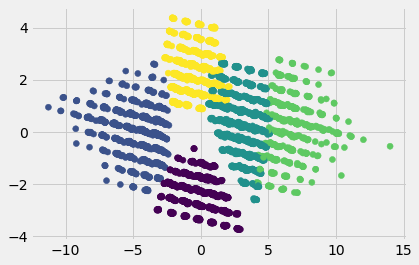

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.cluster import MiniBatchKMeans

mini = MiniBatchKMeans(n_clusters = 5, random_state = 0)
cluster_df = get_silhouette_score(train, mini)

## Classification

In [ ]:
cluster_df.head()

,gender,age,income,knowledge,exp,risk,term,s1,s2,s3,s4,s5,score,target
0,0,3,0,0,1,0,2,2.0,1.0,2.0,3.0,2.0,16.0,1
1,1,4,0,0,3,0,1,3.0,2.0,2.0,3.0,2.0,21.0,0
2,1,4,3,0,2,1,3,3.0,1.0,1.0,2.0,1.0,22.0,2
3,0,2,1,0,0,2,1,3.0,1.0,1.0,3.0,2.0,16.0,1
4,0,0,2,0,0,0,0,3.0,2.0,2.0,3.0,2.0,14.0,1


In [ ]:
y = cluster_df["target"]
X = cluster_df.drop("target", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [8, 12, 18],
    'min_samples_split': [8, 16, 20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5)
grid_cv.fit(X_train , y_train)

print(f'최적의 하이퍼 파라미터: {grid_cv.best_params_}')
print(f'최고 예측 정확도: {grid_cv.best_score_:.4f}')

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=8, min_samples_split=8, random_state=0)
rf_clf.fit(X_train, y_train)
X_test['target'] = rf_clf.predict(X_test)
print('The accuracy of the Random Forests is', accuracy_score(X_test['target'], y_test))

The accuracy of the Random Forests is 0.9471794871794872


In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred, average='micro')
    recall = recall_score(y_test , pred, average='macro')
    f1 = f1_score(y_test,pred,average='macro')
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class="ovr")
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

#예측 성능 평가
proba = rf_clf.predict_proba(X_test.drop(['target'], axis=1))
get_clf_eval(y_test,X_test['target'],proba)

오차 행렬
[[426   6   1   0   2]
 [  0 480   0   0   0]
 [ 17   0 431   0   3]
 [  1   0  13 155   0]
 [ 35  14  11   0 355]]
정확도: 0.9472, 정밀도: 0.9472, 재현율: 0.9415, F1: 0.9470, AUC:0.9972


### Feature importance

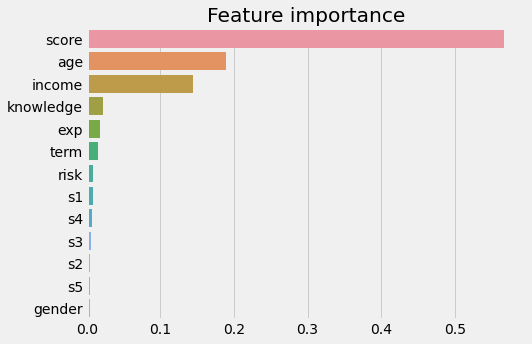

In [ ]:
ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top = ftr_importances.sort_values(ascending=False)
plt.figure(figsize=(7, 5))
plt.title('Feature importance')
sns.barplot(x=ftr_top, y = ftr_top.index)
plt.show()

In [ ]:
def desc(X, col):
    targets = []
    target_type = X.groupby('target')[col].mean().sort_values().index

    for i in target_type:
        target = X[X['target']==i][col].describe()
        targets.append(target)

    target_df = pd.DataFrame(targets).T
    target_df.columns = target_type
    return target_df

In [ ]:
test['target'] = rf_clf.predict(test)
test.head()

,gender,age,income,knowledge,exp,risk,term,s1,s2,s3,s4,s5,score,target
0,0,1,2,0,2,1,2,3,3,3,1,3,21,2
1,0,3,1,0,2,0,1,1,3,1,3,2,17,0
2,1,3,1,0,2,0,0,3,3,1,1,2,17,0
3,0,4,3,0,3,0,1,1,2,3,1,1,19,0
4,1,1,4,1,2,0,3,3,3,3,3,2,26,3


In [ ]:
desc(test, 'score')

target,1,4,0,2,3
count,554.000000,563.000000,659.000000,772.000000,452.000000
mean,14.530686,18.374778,19.166920,21.797927,25.734513
std,1.589965,1.191549,1.448004,1.181613,1.795623
min,7.000000,16.000000,17.000000,18.000000,24.000000
25%,14.000000,17.000000,18.000000,21.000000,24.000000
50%,15.000000,18.000000,19.000000,22.000000,25.000000
75%,16.000000,19.000000,20.000000,23.000000,26.250000
max,16.000000,24.000000,24.000000,27.000000,33.000000


In [ ]:
desc(test, 'age')

target,4,1,2,3,0
count,563.000000,554.000000,772.000000,452.000000,659.000000
mean,0.573712,1.072202,1.913212,2.758850,3.060698
std,0.580972,1.166990,1.367202,1.250024,0.800429
min,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,1.000000,2.000000,2.000000
50%,1.000000,1.000000,2.000000,3.000000,3.000000
75%,1.000000,2.000000,3.000000,4.000000,4.000000
max,2.000000,4.000000,4.000000,4.000000,4.000000


In [ ]:
desc(test, 'risk')

target,1,0,4,2,3
count,554.000000,659.000000,563.000000,772.000000,452.000000
mean,0.512635,0.707132,0.728242,0.772021,1.044248
std,0.670229,0.774279,0.763282,0.814808,0.902221
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000


In [ ]:
desc(test, 'income')

target,0,1,4,2,3
count,659.000000,554.000000,563.000000,772.000000,452.000000
mean,0.854325,0.889892,1.579041,2.939119,3.316372
std,0.852330,1.055669,1.446085,1.583040,1.624206
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,2.000000
50%,1.000000,1.000000,1.000000,3.000000,4.000000
75%,1.000000,1.000000,2.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000


In [ ]:
desc(test, 'knowledge')

target,1,0,4,2,3
count,554.000000,659.000000,563.000000,772.000000,452.000000
mean,0.518051,0.732929,0.918295,0.987047,1.588496
std,0.884178,1.033626,1.122594,1.136513,1.220174
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,2.000000,2.000000,3.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000


In [ ]:
desc(test, 'exp')

target,1,0,4,2,3
count,554.000000,659.000000,563.000000,772.000000,452.000000
mean,1.243682,1.573596,1.715808,1.857513,2.059735
std,1.060641,1.020445,0.989742,0.921234,0.838893
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,2.000000
50%,1.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,3.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000


In [ ]:
desc(test, 's1')

target,1,0,4,2,3
count,554.000000,659.000000,563.000000,772.000000,452.000000
mean,1.992780,2.490137,2.531083,2.591969,2.995575
std,1.020558,1.076614,1.109812,1.125388,1.038068
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,3.000000,3.000000,3.000000
75%,3.000000,3.000000,4.000000,4.000000,4.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000


In [ ]:
desc(test, 's2')

target,1,0,4,2,3
count,554.000000,659.000000,563.000000,772.000000,452.000000
mean,1.712996,1.957511,2.030195,2.077720,2.287611
std,0.790274,0.809152,0.807534,0.814379,0.771744
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,2.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,3.000000,3.000000,3.000000,3.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000


<pre>
안정형: 1
안정추구형: 0
위험중립형: 4
적극투자형: 2
공격투자형: 3
</pre>